# Inverse filter

In [3]:
import numpy as np
import scipy
from scipy import signal
from skimage.io import imread
import matplotlib.pyplot as plt

A random filter

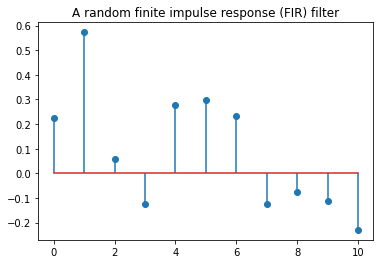

In [4]:
a = np.array([1])
L = 10
# sigma = 2
# b = signal.gaussian(L+1, sigma)
b = np.random.normal(0, 0.1, L+1)
b = b / sum(b)
plt.stem(b)
plt.title('A random finite impulse response (FIR) filter')
plt.savefig('randFIR.pdf', format='pdf', bbox_inches='tight')

1D filtering

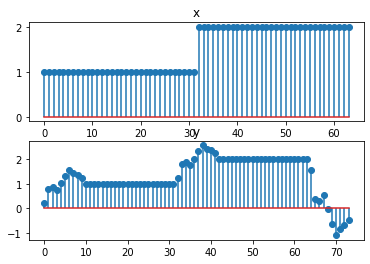

In [5]:
x = np.concatenate((np.ones(32), 2*np.ones(32)))
y = signal.lfilter(b, a, np.append(x, np.zeros(L)))
plt.subplot(211)
plt.stem(x)
plt.title('x')
plt.subplot(212)
plt.stem(y)
plt.title('y')
plt.savefig('1D_filtering.pdf', format='pdf', bbox_inches='tight')

2D separable filtering

In [6]:
def lfilter2(b, a, im):
    L = b.size - 1
    im1 = signal.lfilter(b, a, np.append(im, np.zeros((L, im.shape[1])), axis=0), axis=0)
    im2 = signal.lfilter(b, a, np.append(im1, np.zeros((im1.shape[0], L)), axis=1), axis=1)
    return im2

Test image

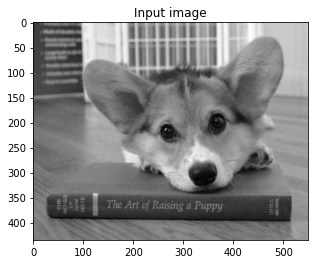

In [7]:
im = imread('resources/test-image.jpg')
plt.imshow(im, 'gray');
plt.title('Input image')
plt.savefig('input_im.pdf', format='pdf', bbox_inches='tight')

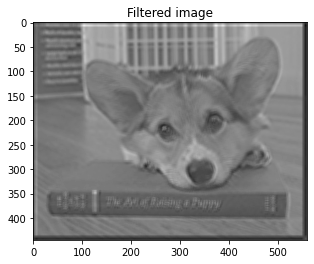

In [8]:
im2 = lfilter2(b, a, im)
plt.imshow(im2, 'gray')
plt.title('Filtered image')
plt.savefig('filtered_im.pdf', format='pdf', bbox_inches='tight')

Factorize $B(z) = B_i(z) B_o(z)$ where $B_i(z)$ and $B_o(z)$ have roots inside and outside the unit circle, respectively.

In [9]:
r = np.roots(b)
ri = r[np.abs(r) < 1]
ro = r[np.abs(r) >= 1]
bi = np.poly(ri)
bo = np.poly(ro)

np.set_printoptions(precision=2)
print('abs(r) =', np.abs(r))
print('bi = ', bi)
print('bo = ', bo)

abs(r) = [2.22 1.   1.   0.93 0.93 1.04 1.04 0.83 0.77 0.77]
bi =  [ 1.    1.84  1.31  0.41 -0.46 -0.6  -0.61 -0.42]
bo =  [ 1.    0.68 -2.32  2.41]


In [10]:
# Verify factorization
b2 = np.convolve(bi, bo) * b[0]
print('b2 - b = ', b2 - b)

b2 - b =  [ 0.00e+00  1.44e-15  1.29e-15 -1.44e-15  7.77e-16  2.83e-15  1.78e-15
  7.22e-16 -1.39e-17 -4.86e-16 -1.36e-15]


In [11]:
# Causal filter with poles inside unit circle
w = signal.lfilter(a, bi, y)

In [12]:
# Anti-causal filter with poles outside unit circle
# Flip signal and coefficients for anti-causal computation
K = bo.size
af = np.zeros(K)
af[K-1] = 1
bof = np.flip(bo)
xr = np.flip(signal.lfilter(af, bof, np.flip(w))) / b[0]

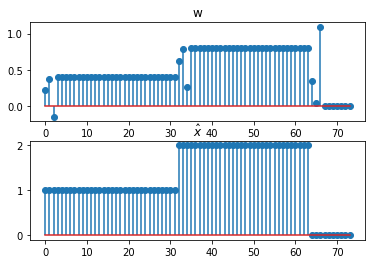

In [13]:
plt.subplot(211)
plt.stem(w)
plt.title('w')
plt.subplot(212)
plt.stem(xr)
plt.title('$\hat{x}$')
plt.savefig('inverse_proc.pdf', format='pdf', bbox_inches='tight')

In [14]:
def inverse_filter(b, y):
    # Factorize B(z) = B_i(z) B_o(z), where B_i and B_o have roots inside and outside unit circle
    r = np.roots(b)
    ri = r[np.abs(r) < 1]
    ro = r[np.abs(r) >= 1]
    bi = np.poly(ri)
    bo = np.poly(ro)
    
    # Causal filter with poles inside unit circle
    w = signal.lfilter(a, bi, y)
    
    # Anti-causal filter with poles outside unit circle
    # Flip signal and coefficients for anti-causal computation
    K = bo.size
    af = np.zeros(K)
    af[K-1] = 1
    bof = np.flip(bo)
    xr = np.flip(signal.lfilter(af, bof, np.flip(w))) / b[0]
    
    # Truncate added zeros due to extended filtering
    return xr[:-b.size+1]

Reconstruction error xr2 - x = 
 [-1.11e-16  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00 -8.88e-16  8.88e-16 -2.66e-15  5.33e-15 -1.15e-14  2.58e-14
 -5.68e-14  1.26e-13 -2.81e-13  6.21e-13 -1.38e-12  3.06e-12 -6.79e-12
  1.51e-11 -3.35e-11  7.42e-11 -1.65e-10  3.66e-10 -8.12e-10  1.80e-09
 -4.00e-09  8.87e-09 -1.97e-08  4.37e-08 -9.70e-08  2.15e-07 -4.78e-07
  1.06e-06 -2.35e-06  5.22e-06 -1.16e-05  2.57e-05 -5.71e-05  1.27e-04
 -2.81e-04  6.24e-04 -1.39e-03  3.07e-03 -6.82e-03  1.51e-02 -3.36e-02
  7.46e-02 -1.66e-01  3.67e-01 -8.15e-01  1.81e+00 -4.02e+00  8.91e+00
 -1.98e+01  4.39e+01 -9.75e+01  2.16e+02 -4.80e+02  1.07e+03 -2.36e+03
  5.25e+03]


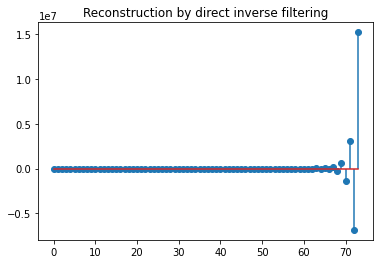

In [15]:
xr2 = signal.lfilter(a, b, y)
plt.stem(xr2)
plt.title('Reconstruction by direct inverse filtering')
plt.savefig('direct_inverse.pdf', format='pdf', bbox_inches='tight')
e = xr2[:-b.size+1] - x
np.set_printoptions(precision=2)
print('Reconstruction error xr2 - x = \n', e)

Text(0.5, 1.0, 'Reconstruction by causal + anti-causal inverse filtering')

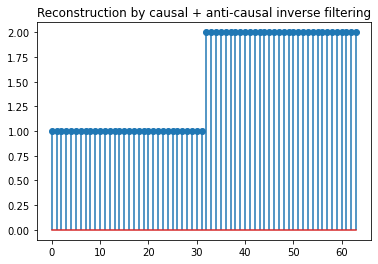

In [16]:
xr = inverse_filter(b, y)
plt.stem(xr)
plt.title('Reconstruction by causal + anti-causal inverse filtering')

## Consider adding noise

In [17]:
e = np.random.normal(0, 0.01, y.size)

Text(0.5, 1.0, 'Reconstruction by direct inverse filter')

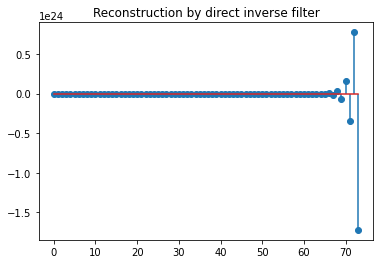

In [18]:
xr2 = signal.lfilter(a, b, y+e)
plt.stem(xr2)
plt.title('Reconstruction by direct inverse filter')

Text(0.5, 1.0, 'Reconstruction by causal + anti-causal inverse filtering')

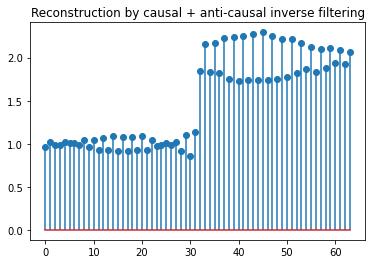

In [19]:
xr = inverse_filter(b, y+e)
plt.stem(xr)
plt.title('Reconstruction by causal + anti-causal inverse filtering')

2D inverse filtering

In [20]:
def inverse_filter2(b, y):
    # Factorize B(z) = B_i(z) B_o(z), where B_i and B_o have roots inside and outside unit circle
    r = np.roots(b)
    ri = r[np.abs(r) < 1]
    ro = r[np.abs(r) >= 1]
    bi = np.poly(ri)
    bo = np.poly(ro)
    
    # Causal filter with poles inside unit circle
    w1 = signal.lfilter(a, bi, y, axis=0)
    w2 = signal.lfilter(a, bi, w1, axis=1)
    
    # Anti-causal filter with poles outside unit circle
    # Flip signal for anti-causal computation
    K = bo.size - 1
    bof = np.flip(bo)
    af = np.append(np.zeros(K), np.array([1]))
    xr1 = np.flip(signal.lfilter(af, bof, np.flip(w2, axis=0), axis=0), axis=0) / b[0]
    xr2 = np.flip(signal.lfilter(af, bof, np.flip(xr1, axis=1), axis=1), axis=1) / b[0]
    
    # Truncate the added zeros from extended filtering
    return xr2[:-b.size+1, :-b.size+1]

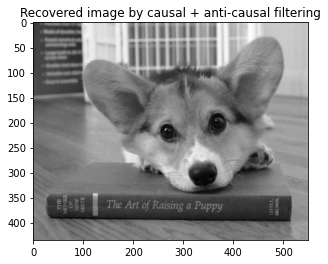

In [21]:
imr = inverse_filter2(b, im2)
plt.imshow(imr, 'gray', vmin=0, vmax=255)
plt.title('Recovered image by causal + anti-causal filtering')
plt.savefig('inverse_proc_im.pdf', format='pdf', bbox_inches='tight')

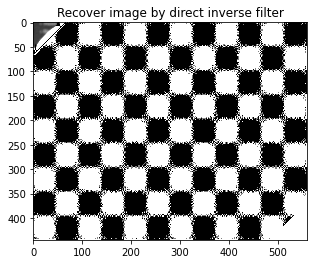

In [22]:
imr2 = lfilter2(a, b, im2)
plt.imshow(imr2, 'gray', vmin=0, vmax=255)
plt.title('Recover image by direct inverse filter')
plt.savefig('direct_inverse_im.pdf', format='pdf', bbox_inches='tight')